In [1]:
#IMPORTS 
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r"C:\Users\DGaard\Desktop\Gits\MoleculeSim\ownSim")
#sys.path.append(r"C:\Users\EmilR\Documents\GitHub\MoleculeSim\ownSim")

#import forces as fc
import molecules as mc
import img3dto2d as i32
import util
#import random
#import copy
#from tqdm import tqdm

#mayavi imports:
from __future__ import absolute_import, division, print_function
from mayavi import mlab
import math

#stats:
import stats as st
from tqdm import tqdm

#video imports 
sys.path.append(r"C:\Users\DGaard\Desktop\Gits\MoleculeSim\videoStuff")
import video_format as vf
from skimage.transform import resize, rescale
from skimage.morphology import label

********************************************************************************
         to build the TVTK classes (9.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



In [2]:
def old_load(name):
  with open(name, 'rb') as f:
    poss = np.load(f)
    radii = np.load(f)
  return poss, radii

In [3]:
#example runs:
#259 molecules (4000,4000) stepsize 1 - not much happens - simV3R_1000_4000_214142_1_1000_1bd67.npy


#vol frac 13% max runs different stepsizes:
# 3 - simV3R_500_8000_1414_3_1000_de453.npy -
# 5 - simV3R_500_8000_1414_5_1000_7c3ec.npy - 
# 7 - simV3R_500_8000_1417_7_1000_239bb.npy -
# 9 - simV3R_500_8000_1416_9_1000_8c033.npy -

#vol frac 6% max runs different stepsizes 500_000 - some coagulation, but not giga clear
# 3 - simV3R_500_8000_1414_3_1000_cf794.npy
# 5 - simV3R_500_8000_1414_5_1000_c291e.npy
# 7 - simV3R_500_8000_1414_7_1000_cae27.npy


# ---- tests to find clear coagulation visualisation ---
#vol frac 6% 4000, 500_000:
#5 - simV3R_500_4000_214142_5_1000_f95f1.npy - viser godt koagulation

#vol frac 3% 4000, 500_000:
# 5 - simV3R_500_4000_214142_5_1000_75dfb.npy - meget koagulation





#example tests for Coagulation:
#65 mols, (4000,4000) ss = 9 ,100_000- images show clearer coagulation  - simV3R_100_4000_214142_9_1000_75c57.npy
#65 4000 200_00 5 - 0.06  -simV3R_200_3000_214142_5_1000_66d8a.npy

#65 2500 200_000 5 0.10 - coagulation ikke helt så god - simV3R_200_2500_214142_5_1000_72d01.npy

In [4]:
# load radius and all molecule positions
filename = "simV3R_500_4000_214142_5_1000_75dfb.npy"#"simV3R_500_8000_1416_9_1000_8c033.npy"#"simV3R_1000_4000_214142_5_1000_dc035.npy"#"simV3R_500_4000_1414_5_1000_802c4.npy" #"simV3R_100_3000_1414_5_1000_8c01e.npy" #"simV3R_500_2000_1414_5_1000_d48e0.npy"#"simV3R_20_8000_1414_5_1000_ab233.npy"#"simV3R_500_3952_1416_5_1000_b3409.npy"
filename_split = filename.split("_")
#points, radii= old_load(filename)
points, radii, acc = mc.load_molecule_steps(filename)

#sim values:
num_frames = int(filename_split[1]) #can be stored at eg. 100 steps pr frame (to save space)
num_molecules = len(points[0])
size_const = int(filename_split[2])
seed = int(filename_split[3])
max_stepsize =  int(filename_split[4])
skip_frames = int(filename_split[5])
box_size = np.array([size_const,size_const,1000]) #may need to set the z value to differently

#image values
image_size = np.array([size_const,size_const])
sigma_scale = 1.5 #gauss values for individual circles
sigma_smooth = 100 #gauss smoothing

frames = [0,len(points) - 1] #select frames to plot
print("total frames", num_frames * skip_frames, "stored frames:" , num_frames, "molecules:",  num_molecules ," image size:", image_size , "seed:",seed, "max stepsize:",max_stepsize)

total frames 500000 stored frames: 500 molecules: 59  image size: [4000 4000] seed: 214142 max stepsize: 5


In [5]:
#plot
plot_imgs = True#False#
radius_plot = True#False#

animate =  True#False#
video = True#False#

#stats:
stats =True #False #
avg_dist_stats = False#True#
overlap_stats = False #True#
avg_kdist_stats =True#False#
rate_stats = True#False #

In [6]:
#volume fraciton:
box_vol = int(box_size[0])*int(box_size[1])*int(box_size[2])
sphere_vol = 0
for r in radii:
  sphere_vol += ((4/3)*r**3*np.pi)

print("Density: ", sphere_vol/box_vol)

Density:  0.036187484481029195


0it [00:00, ?it/s]

2it [00:19,  9.90s/it]


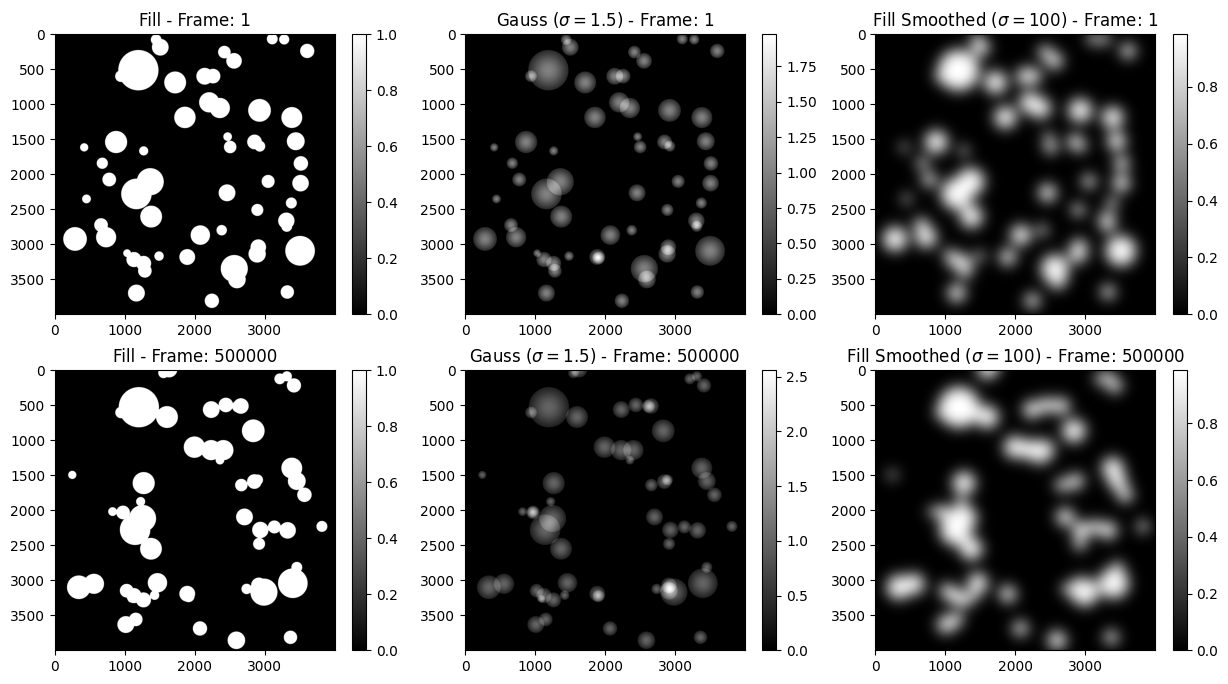

In [7]:
imgs_gauss = []
imgs_fill = []
imgs_fill_smooth = []

if plot_imgs:
  #plot frames

  plt.figure(figsize=(15,4*len(frames)))
  for i,f in tqdm(enumerate(frames)):
    
    _p2dr = list(zip(np.array(points[f])[:,:2],radii)) # all depths

    #specific depths
    #depth = xxxx
    #_test = [points[f][x] for x in range(num_molecules) if points[f][x][2] < (depth)]
    #_p2dr = list(zip(np.array(_test)[:,:2],radii))

    _frame_val = f #this conversion probably works best for first and last frame (may need the verify)
    if f == 0:
      _frame_val = 1
    else:
      _frame_val = (_frame_val + 1) * skip_frames

    #Hard fill
    plt.subplot(len(frames),3,(i)*3+1)
    plt.title(f"Fill - Frame: {_frame_val}")
    _img_fill = i32.get_3d_to_2d_img(_p2dr,image_size)

    im_ratio = _img_fill.shape[0]/_img_fill.shape[1]
    plt.imshow(_img_fill,cmap="gray")
    plt.colorbar(fraction=0.045 * im_ratio)

    #gauss fill
    plt.subplot(len(frames),3,(i)*3+2)
    plt.title(f"Gauss ($\sigma =${sigma_scale}) - Frame: {_frame_val}")
    _img_gauss = i32.get_3d_to_2d_img_gauss(_p2dr,image_size,sigma_scale)
    plt.imshow(_img_gauss,cmap="gray")
    plt.colorbar(fraction=0.045 * im_ratio)

    #gauss on hard fill:
    plt.subplot(len(frames),3,(i)*3+3)
    plt.title(f"Fill Smoothed ($\sigma =${sigma_smooth}) - Frame: {_frame_val}")
    _img_smooth = i32.gauss2dimg(_img_fill,sigma_smooth)
    plt.imshow(_img_smooth,cmap="gray")
    plt.colorbar(fraction=0.045 * im_ratio)

    imgs_fill.append(_img_fill)
    imgs_gauss.append(_img_gauss)
    imgs_fill_smooth.append(_img_smooth)

  plt.show()

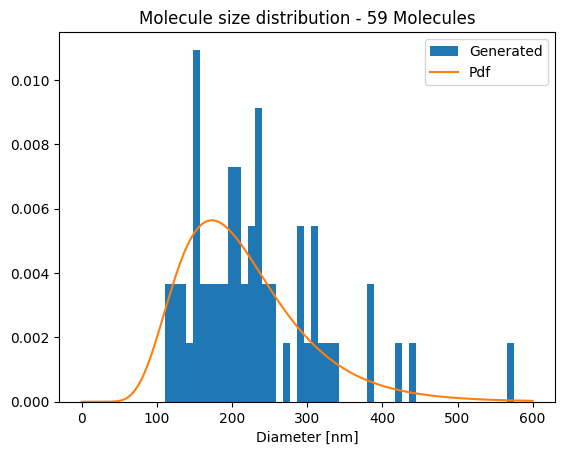

In [8]:
#radius distribution
if radius_plot:
  x = np.linspace(0.1,600, 1000)
  res = [util.pdf(i) for i in x]

  plt.figure()
  plt.hist(radii * 2,bins = 50, density = True,label="Generated")
  plt.plot(x,res,label="Pdf")
  plt.title(f"Molecule size distribution - {num_molecules} Molecules")
  plt.legend()
  plt.xlabel("Diameter [nm]")
  plt.show()

100%|██████████| 50/50 [00:00<00:00, 155.83it/s]


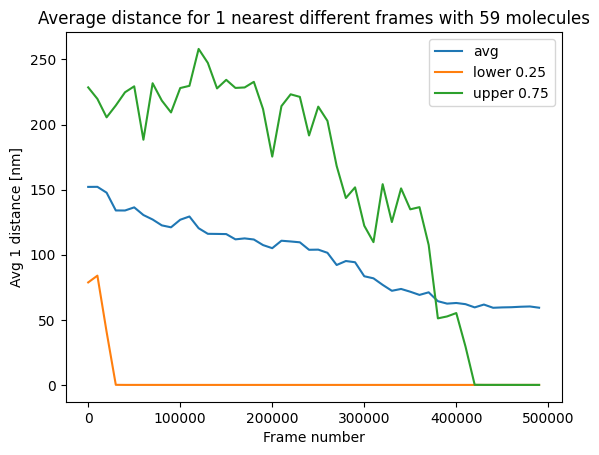

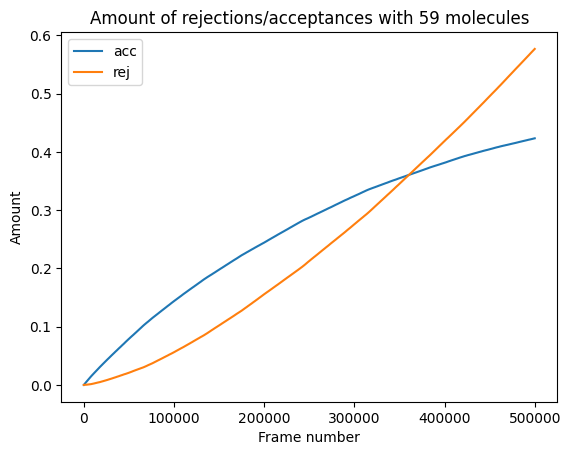

In [9]:
skip_stats = 10
frame_nums = [x for x in range(0,num_frames,skip_stats)]
frame_nums_text = [x*skip_frames for x in range(0,num_frames,skip_stats)]
points_skiped = [points[x] for x in frame_nums]

if stats:
  if avg_dist_stats:
    avg_dists = st.avg_dist(points_skiped,radii)
    #plot avg distance
    plt.plot(frame_nums_text,avg_dists)
    plt.title(f"Average distance for different frames with {num_molecules} molecules")
    plt.xlabel("Frame number")
    plt.ylabel("Avg distance [nm]")
    plt.show()
  
  if overlap_stats:
    overlaps = st.check_for_overlap(points_skiped, radii)

    #plot avg distance
    plt.plot(frame_nums_text,overlaps)
    plt.title(f"Overlaps with {num_molecules} molecules")
    plt.xlabel("Frame number")
    plt.ylabel("Amount")
    plt.show()

  if avg_kdist_stats:
    k = 1
    upper = 0.75
    lower = 0.25
    k_dists,k_lower,k_upper = st.avg_k_dist(points_skiped,radii,k,upper=upper,lower=lower)

    #plot avg distance
    plt.plot(frame_nums_text,k_dists,label=f"avg")
    plt.plot(frame_nums_text,k_lower,label=f"lower {lower}")
    plt.plot(frame_nums_text,k_upper,label=f"upper {upper}")
    plt.title(f"Average distance for {k} nearest different frames with {num_molecules} molecules")
    plt.xlabel("Frame number")
    plt.ylabel(f"Avg {k} distance [nm]")
    plt.legend()
    plt.show()

  if rate_stats:
    acceptances, rejections = st.mc_rate(acc)

    #plot acceptance and rejectance 
    plt.plot(acceptances,label="acc")
    plt.plot(rejections,label="rej")
    plt.title(f"Amount of rejections/acceptances with {num_molecules} molecules")
    plt.xlabel("Frame number")
    plt.ylabel("Amount")
    plt.legend()
    plt.show()


In [10]:
#mayavi visualize


#max_radius = max(radii)
#print(max_radius)
if animate:

	xs = np.array([inner_list[0] for sublist in points for inner_list in sublist]).reshape((num_frames,num_molecules))
	ys = np.array([inner_list[1] for sublist in points for inner_list in sublist]).reshape((num_frames,num_molecules))
	zs = np.array([inner_list[2] for sublist in points for inner_list in sublist]).reshape((num_frames,num_molecules))
	mlab.clf()
	#mlab.points3d(0,0,0)

	# plt = mlab.points3d([0], [0], [0], resolution = 100, scale_factor = 100*2)
	# plt = mlab.points3d([300], [0], [0], resolution = 100, scale_factor = 200*2)
	#plt = mlab.points3d(points[0][:, 0], points[0][:, 1], points[0][:, 2], resolution = 10, scale_factor = radius*2)
	plt2 = mlab.points3d(points[0][:, 0], points[0][:, 1], points[0][:, 2], radii*2, resolution = 10, scale_mode = "scalar", scale_factor = 1)
	mlab.axes(extent = [0,box_size[0],0,box_size[1],0,box_size[2]])#ranges = [-100,500,-200,200,-200,200]
	text_position = (0,0,0)
	text_actor = mlab.text3d(500,150, 510, "TESTING", scale = 40, color = (0,0,0))
	@mlab.animate(delay = 100, ui = True, support_movie = True) #delay = 100
	def anim():
		f = mlab.gcf()
		while True:
			#temp = "step: "
			for step in range(len(xs)):#num_steps
				x = xs[step]#points[step][:, 0]
				y = ys[step]#points[step][:, 1]
				z = zs[step]#points[step][:, 2]
				plt2.mlab_source.set(x=x, y=y, z=z)
				# for i in range(num_molecules):
  			# 		plt[i].mlab_source.set(x=x[i], y=y[i], z=z[i])
				text_actor.text = f"Frame: {step}"
				
				yield


	anim()
	mlab.show()

In [11]:
box_size

array([4000, 4000, 1000])

10 10


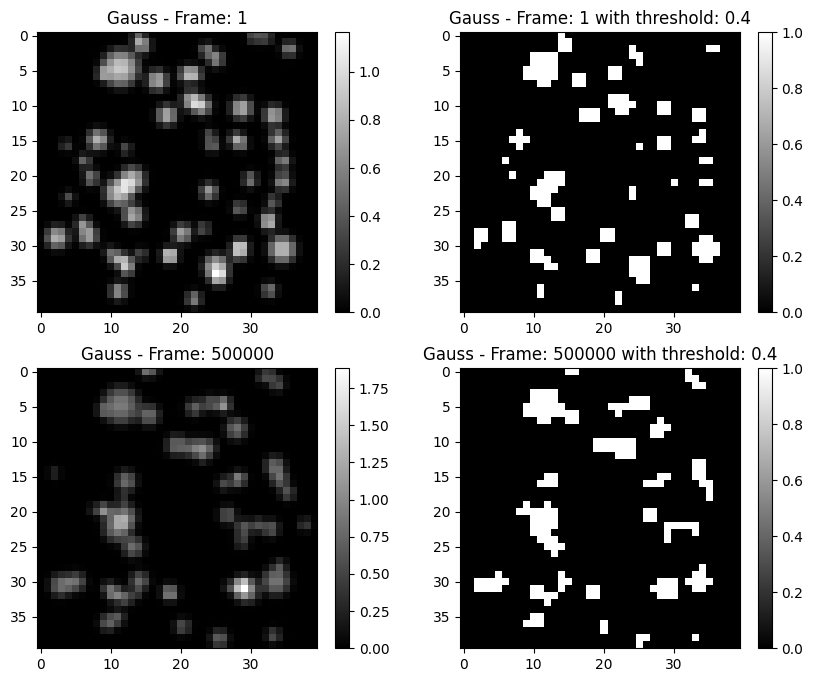

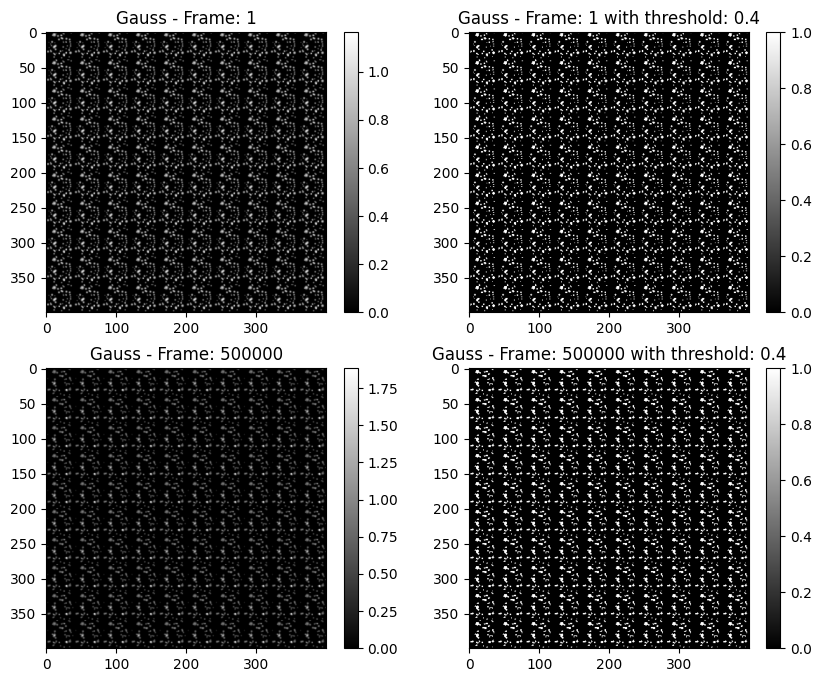

cells start 3200 Cells end: 2100
end area fraction ours: 0.110625


In [33]:
#image stuff:

def process_our_image(img):
  #need to smooth?
  #remove boarder?

  return label(img)

L= 50

#apply threshold:
threshold = 0.4

wanted_image_size = np.array([400,400]) #video size
scaled_img_size = np.array([box_size[0]/100,box_size[1]/100]) #1 pixel in original video is 100 nm

dupX = int(wanted_image_size[1]/scaled_img_size[1])
dupY = int(wanted_image_size[0]/scaled_img_size[0])
print(dupX,dupY)

image_frames = [resize(i,scaled_img_size) for i in imgs_gauss]
#image_frames = [resize(i,scaled_img_size) for i in imgs_fill_smooth]

image_frames_duplicated = [i32.duplicate_image(img,dupX,dupY) for img in image_frames]

#image_frames = [resize(i,scaled_img_size) for i in imgs_gauss]

#image_frames = [rescale(i,0.1) for i in imgs_gauss]


th_imgs = []


plt.figure(figsize=(10,4*len(image_frames)))
for i,img in enumerate(image_frames):

  _frame_val = frames[i] #this conversion probably works best for first and last frame (may need the verify)
  if frames[i] == 0:
    _frame_val = 1
  else:
    _frame_val = (_frame_val + 1) * skip_frames

  plt.subplot(len(imgs_gauss),2,(i)*2+1)
  plt.title(f"Gauss - Frame: {_frame_val}")
  plt.imshow(img,cmap="gray")

  im_ratio = img.shape[0]/img.shape[1]
  plt.colorbar(fraction=0.045 * im_ratio)

  plt.subplot(len(imgs_gauss),2,(i)*2+2)
  plt.title(f"Gauss - Frame: {_frame_val} with threshold: {threshold}")
  _img_gauss_th = np.where(img > threshold,1,0)
  plt.imshow(_img_gauss_th,cmap="gray")
  plt.colorbar(fraction=0.045 * im_ratio)

  #th_imgs.append(_img_gauss_th)
plt.show()



plt.figure(figsize=(10,4*len(image_frames)))
for i,img in enumerate(image_frames_duplicated):#enumerate(image_frames):

  _frame_val = frames[i] #this conversion probably works best for first and last frame (may need the verify)
  if frames[i] == 0:
    _frame_val = 1
  else:
    _frame_val = (_frame_val + 1) * skip_frames

  plt.subplot(len(imgs_gauss),2,(i)*2+1)
  plt.title(f"Gauss - Frame: {_frame_val}")
  plt.imshow(img,cmap="gray")

  im_ratio = img.shape[0]/img.shape[1]
  plt.colorbar(fraction=0.045 * im_ratio)

  plt.subplot(len(imgs_gauss),2,(i)*2+2)
  plt.title(f"Gauss - Frame: {_frame_val} with threshold: {threshold}")
  _img_gauss_th = np.where(img > threshold,1,0)
  plt.imshow(_img_gauss_th,cmap="gray")
  plt.colorbar(fraction=0.045 * im_ratio)

  th_imgs.append(_img_gauss_th)
plt.show()
#print(type(th_imgs[0][0,0]))

#apply connected components
cc_imgs = [process_our_image(i) for i in th_imgs]

#print(np.unique(cc_imgs))
print("cells start",max(np.unique(cc_imgs[0])), "Cells end:", max(np.unique(cc_imgs[-1])))
print("end area fraction ours:", np.sum(np.where(cc_imgs[-1]> 0, 1, 0)) / (400*400))
#print("end area fraction video:", np.sum(np.where(used_frame[-1]> 0, 1, 0)) / (400*400)))

F_list, G_list = vf.analyse_video(cc_imgs,L=L)

In [39]:
#info from the video:
threshold2 = 0.3
smooth = 1
skip_size = 24
size = int(wanted_image_size[0])


frames_240= vf.process_video(vf.VIDEO_PATH,threshold=threshold2,smooth=smooth,skip_size=skip_size,size=size)
used_frame = frames_240[:7]

F_list2, G_list2 = vf.analyse_video(used_frame,L=L)

#frames_240= vf.process_video(vf.VIDEO_PATH,threshold=threshold,smooth=smooth,skip_size=skip_size,size=size)
print(len(frames_240))

10


In [34]:
#area of ours
np.sum(np.where(cc_imgs[-1]> 0, 1, 0)) / (400*400)

0.110625

In [15]:
#area of video
np.sum(np.where(used_frame[-1]> 0, 1, 0)) / (400*400)

0.0636125

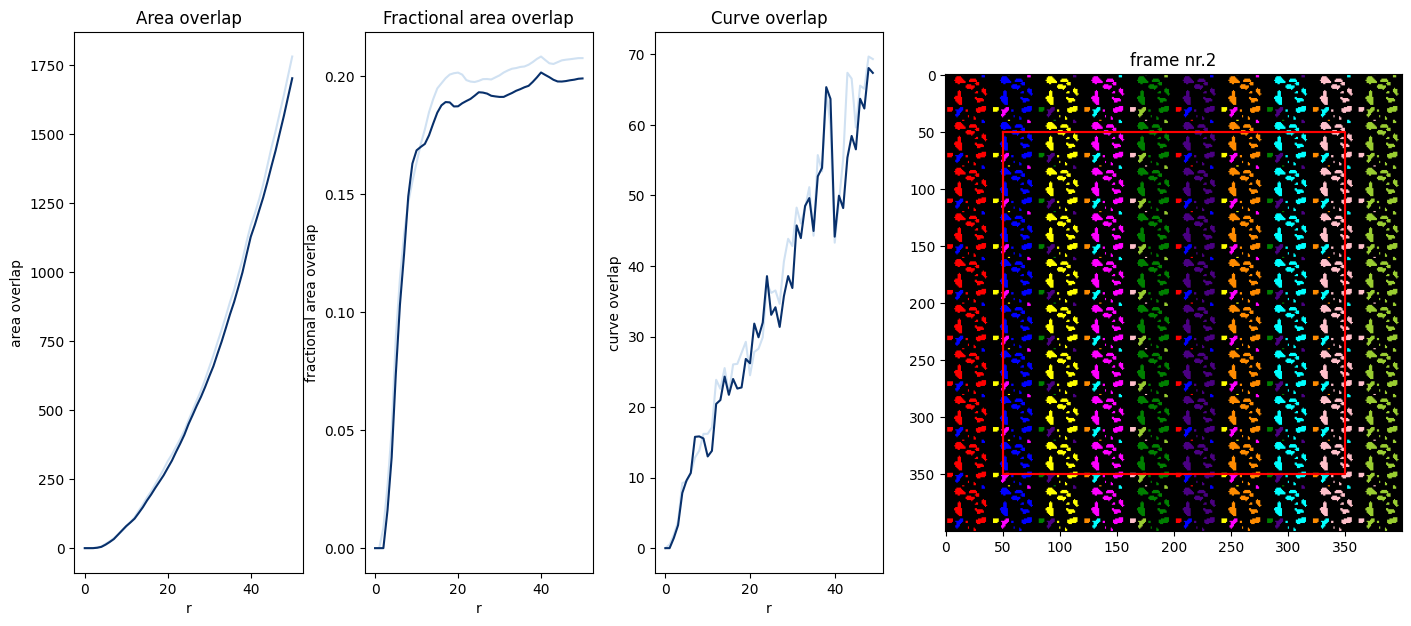

In [19]:
vf.visualize(cc_imgs,F_list,G_list, save=False,L=L)

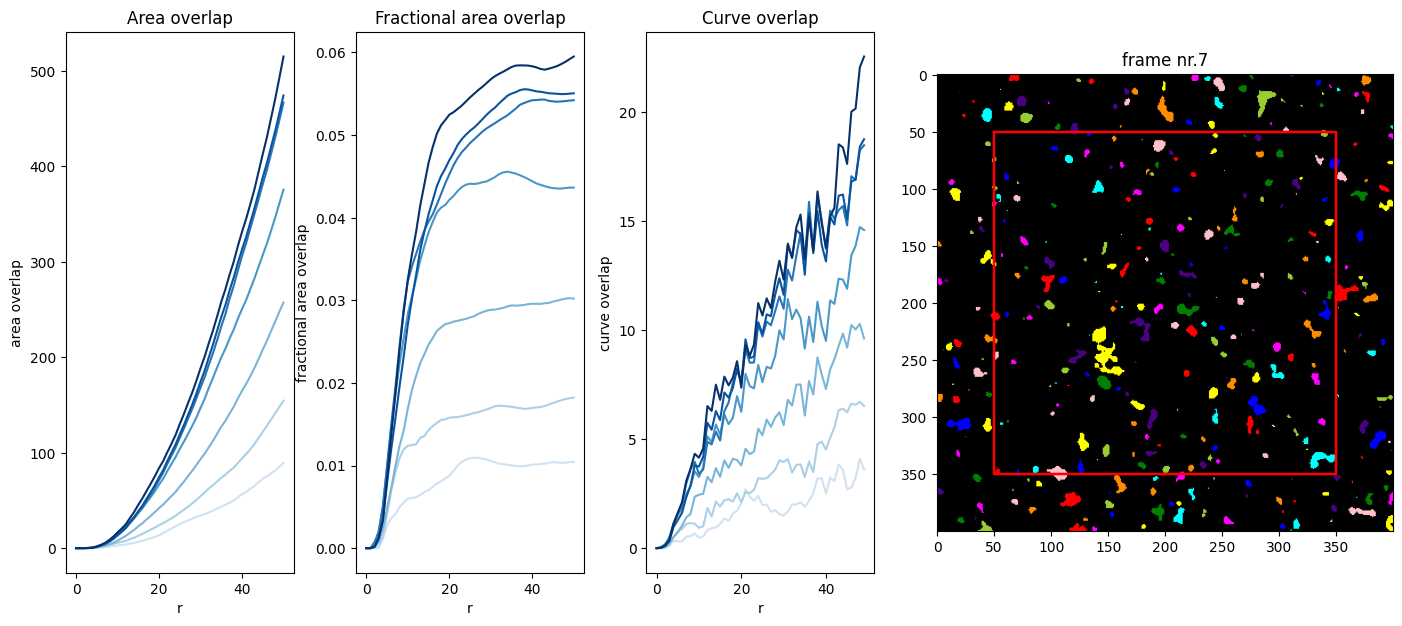

In [40]:
#actual video
vf.visualize(used_frame,F_list2,G_list2,L=L)